In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

In [ ]:
def load_and_preprocess_csv(csv_path, image_size=(28, 28)):
    """
    Loads MNIST-style grayscale CSV and returns train/test sets ready for CNN.

    Args:
        csv_path (str): Path to CSV file.
        image_size (tuple): Target shape (e.g., (28, 28), (64, 64)).

    Returns:
        X_train, X_test, y_train, y_test (all ready for Keras)
    """
    df = pd.read_csv(csv_path)
    pixel_columns = [col for col in df.columns if col.startswith("pixel")]

    # X: normalize pixels
    X = df[pixel_columns].values.astype('float32') / 255.0
    X = X.reshape(-1, image_size[0], image_size[1], 1)

    # y: one-hot encode labels
    lb = LabelBinarizer()
    y = lb.fit_transform(df['label'])

    return train_test_split(X, y, test_size=0.2, random_state=42)



def simple_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



def improved_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def result_summary(title, model, history, X_test, y_test, class_labels=None):
    """
    Summarizes model performance:
    - Accuracy & loss plots
    - Classification report
    - Seaborn confusion matrix

    Args:
        model: Trained Keras model.
        history: History object from model.fit().
        X_test: Test set images.
        y_test: One-hot encoded test labels.
        class_labels: Optional list of class labels (e.g., A–Y).
    """
    # Predictions
    y_pred = model.predict(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    # === Final Accuracy ===
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"[{title}] Final Accuracy:  {acc * 100:.2f}%")
    print(f"[{title}] Final Loss: {loss:.4f}\n")

    # === Classification Report ===
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # === Accuracy & Loss Plots ===
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy ',
            color='red', linestyle='-' , marker = 'o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy ',
            color='blue', linestyle='--', marker ='s')
    plt.title("Model Accuracy " + title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # === Loss Plot ===
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss',
            color='red', linestyle='-', marker = 'o')
    plt.plot(history.history['val_loss'], label='Val Loss',
            color='blue', linestyle='--' , marker = 's')
    plt.title("Model Loss " + title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



    # === Confusion Matrix (Seaborn - Cleaner Layout) ===
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix " + title, fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return loss, acc


def visualize_predictions_confidence(model, X_test, y_test, class_labels, num_samples=5):
    """
    Shows sample images with predicted class and confidence distribution.

    Args:
        model: Trained Keras model.
        X_test: Test images (normalized).
        y_test: One-hot encoded test labels.
        class_labels: List of class names (A–Y).
        num_samples: Number of random samples to display.
    """
    indices = random.sample(range(len(X_test)), num_samples)

    for i in indices:
        img = X_test[i]
        true_label = class_labels[y_test[i].argmax()]
        pred_probs = model.predict(img.reshape(1, *img.shape))[0]
        pred_label = class_labels[pred_probs.argmax()]
        confidence = pred_probs.max() * 100

        # Plot image
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {true_label} | Pred: {pred_label} ({confidence:.1f}%)")
        plt.axis('off')

        # Plot confidence bar chart
        plt.subplot(1, 2, 2)
        plt.bar(class_labels, pred_probs)
        plt.xticks(rotation=45)
        plt.title("Prediction Confidence Distribution")
        plt.ylabel("Probability")
        plt.tight_layout()
        plt.show()


In [ ]:
# Load 28x28 dataset
#X_train_28, X_test_28, y_train_28, y_test_28 = load_and_preprocess_csv("/content/drive/MyDrive/ASL-Project/master_grayscale_28x28.csv", image_size=(28, 28))
#X_train_64, X_test_64, y_train_64, y_test_64 = load_and_preprocess_csv("/content/drive/MyDrive/ASL-Project/master_grayscale_64x64.csv", image_size=(64, 64))
#X_train_224, X_test_224, y_train_224, y_test_224 = load_and_preprocess_csv("/content/drive/MyDrive/ASL-Project/master_grayscale_224x224.csv", image_size=(224, 224))

labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T','U','V','W','X','Y']

In [ ]:
# Default config
TRAINING_CONFIG = {
    "optimizer": tf.keras.optimizers.Adam(learning_rate=1e-3),
    "batch_size": 32,
    "epochs": 50,
    "early_stopping": tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    )
}

# **Simple CNN**

In [ ]:
# Build model for 28x28
model_28_simple = simple_cnn(input_shape=(28, 28, 1), num_classes=len(labels))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history_28_simple = model_28_simple.fit(
    X_train_28, y_train_28,
    epochs=TRAINING_CONFIG["epochs"],
    batch_size=TRAINING_CONFIG["batch_size"],
    validation_data=(X_test_28, y_test_28),
    callbacks=[TRAINING_CONFIG["early_stopping"]],
    verbose=1
)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.0432 - loss: 3.1839 - val_accuracy: 0.0319 - val_loss: 3.1691
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0874 - loss: 3.1161 - val_accuracy: 0.1764 - val_loss: 2.9226
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.2228 - loss: 2.6905 - val_accuracy: 0.3417 - val_loss: 2.4806
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4049 - loss: 2.1730 - val_accuracy: 0.3806 - val_loss: 2.2056
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.4822 - loss: 1.8378 - val_accuracy: 0.4194 - val_loss: 2.0826
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5514 - loss: 1.5379 - val_accuracy: 0.4639 - val_loss: 1.9455
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6173 - loss: 1.3436 - val_accuracy: 0.4764 - val_loss: 1.8880
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.6596 - loss: 1.1552 - val_accuracy: 0.5417 - v

In [ ]:
model_28_simple.save("/content/drive/MyDrive/ASL-Project/models/cnn_simple_28x28.h5")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[Simple CNN (28x28)] Final Accuracy:  55.83%
[Simple CNN (28x28)] Final Loss: 1.7109

Classification Report:
              precision    recall  f1-score   support

           A       0.79      0.54      0.64        35
           B       0.86      0.64      0.74        39
           C       0.57      0.80      0.67        30
           D       0.36      0.56      0.44        25
           E       0.40      0.44      0.42        27
           F       0.72      0.66      0.69        32
           G       0.52      0.44      0.48        34
           H       0.67      0.69      0.68        29
           I       0.73      0.48      0.58        33
           K       0.70      0.53      0.60        30
           L       0.56      0.59      0.57        34
           M       0.57      0.32      0.41        25
           N       0.41      0.33      0.37        27
           O       0.71      0.55      0.62        31
           P       0.29      0.60      0.

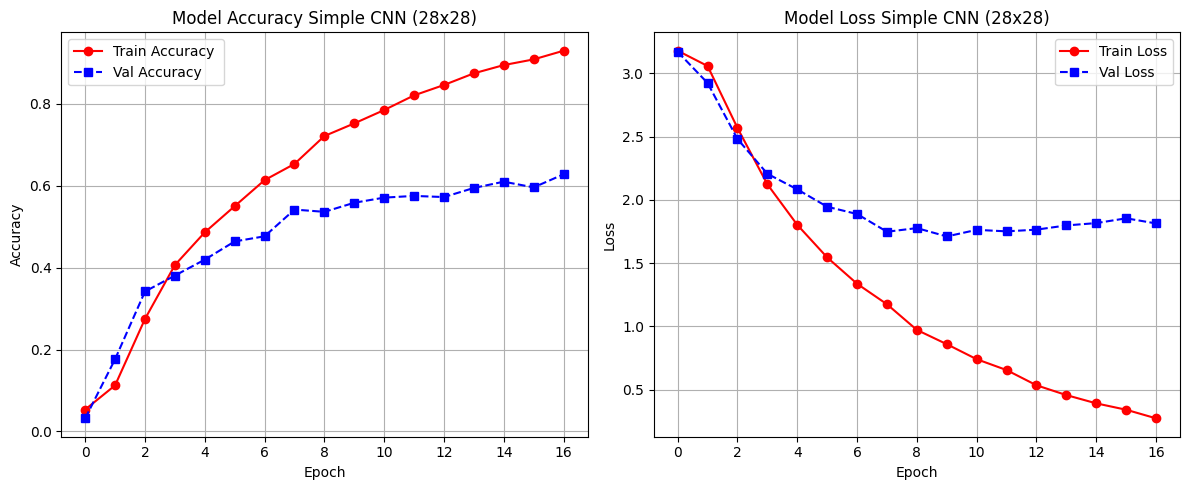

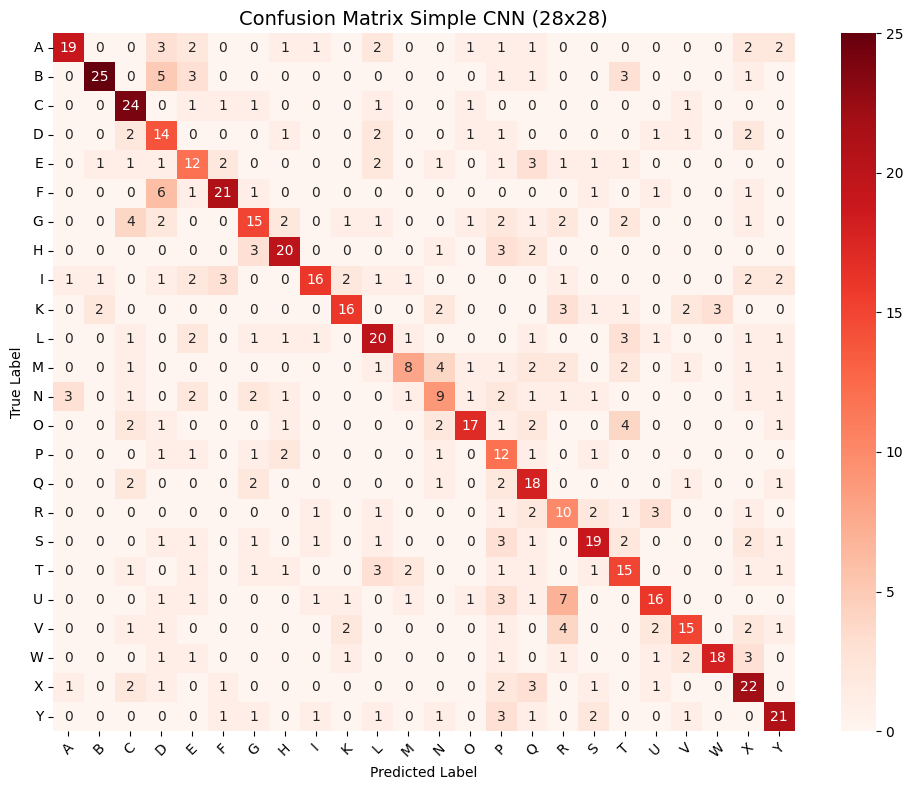

In [ ]:
loss_s_28 , acc_s_28 = result_summary("Simple CNN (28x28)",model_28_simple, history_28_simple, X_test_28, y_test_28, class_labels=labels)


In [ ]:
# Build model for 64x64
model_64_simple = simple_cnn(input_shape=(64, 64, 1), num_classes=len(labels))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history_64_simple = model_64_simple.fit(
    X_train_64, y_train_64,
    epochs=TRAINING_CONFIG["epochs"],
    batch_size=TRAINING_CONFIG["batch_size"],
    validation_data=(X_test_64, y_test_64),
    callbacks=[TRAINING_CONFIG["early_stopping"]],
    verbose=1
)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - accuracy: 0.0428 - loss: 3.1927 - val_accuracy: 0.0875 - val_loss: 3.1395
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - accuracy: 0.1475 - loss: 2.9748 - val_accuracy: 0.3111 - val_loss: 2.5667
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 168ms/step - accuracy: 0.4448 - loss: 2.0296 - val_accuracy: 0.4181 - val_loss: 2.1765
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.6130 - loss: 1.3298 - val_accuracy: 0.4528 - val_loss: 2.1122
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.7459 - loss: 0.8743 - val_accuracy: 0.4778 - val_loss: 2.1683
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - accuracy: 0.8410 - loss: 0.5697 - val_accuracy: 0.4722 - val_loss: 2.3660
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.8979 - loss: 0.3913 - val_accuracy: 0.5181 - val_loss: 2.4272
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.9344 - loss: 0.2662 - val_accu

In [ ]:
model_64_simple.save("/content/drive/MyDrive/ASL-Project/models/cnn_simple_64x64.h5")


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
[Simple CNN (64x64)] Final Accuracy:  45.28%
[Simple CNN (64x64)] Final Loss: 2.1122

Classification Report:
              precision    recall  f1-score   support

           A       0.88      0.40      0.55        35
           B       0.62      0.54      0.58        39
           C       0.80      0.53      0.64        30
           D       0.69      0.44      0.54        25
           E       0.45      0.33      0.38        27
           F       0.37      0.50      0.43        32
           G       0.29      0.32      0.31        34
           H       0.50      0.55      0.52        29
           I       0.56      0.55      0.55        33
           K       0.42      0.43      0.43        30
           L       0.68      0.38      0.49        34
           M       0.50      0.24      0.32        25
           N       0.50      0.33      0.40        27
           O       0.50      0.55      0.52        31
           P       0.26      0.70      0

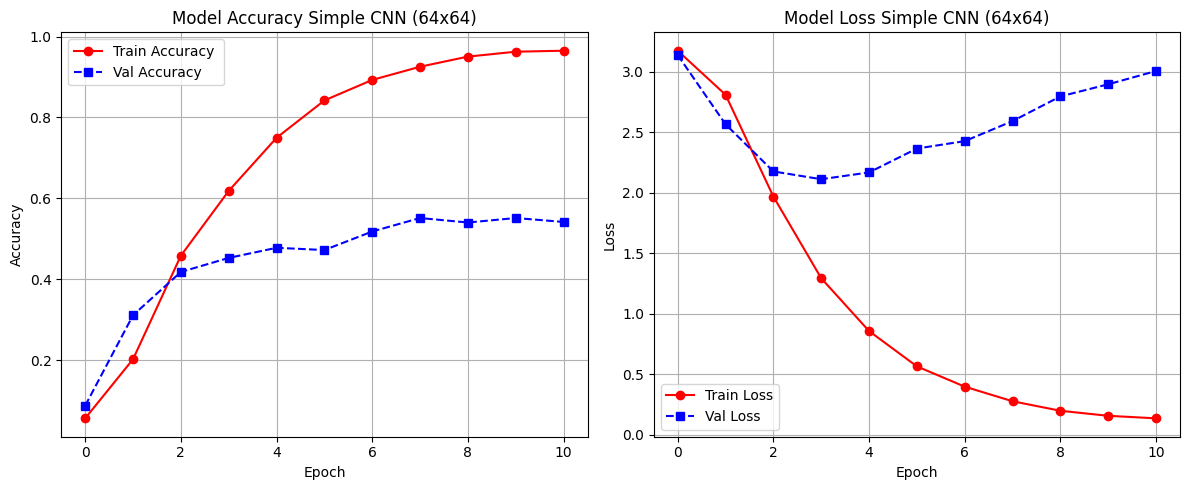

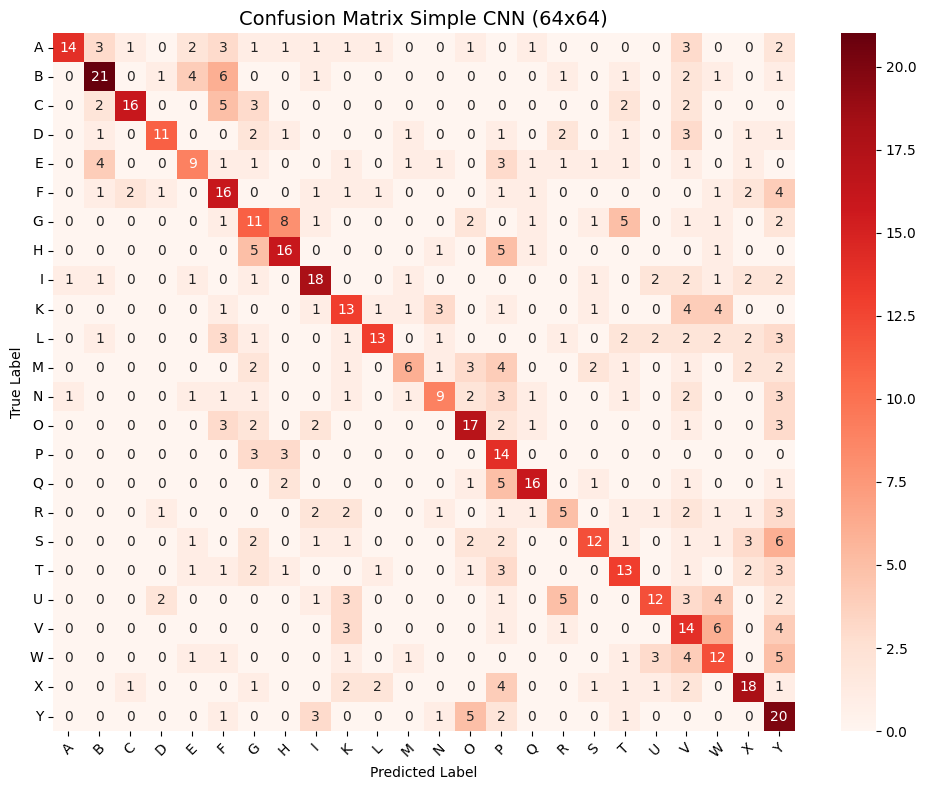

In [ ]:
loss_s_64 , acc_s_64 = result_summary('Simple CNN (64x64)',model_64_simple, history_64_simple, X_test_64, y_test_64, class_labels=labels)


In [ ]:

# Get true and predicted labels
y_true = y_test_28.argmax(axis=1)
y_pred = model_28_simple.predict(X_test_28).argmax(axis=1)

# Report as dict
report_dict = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Keep only per-class rows (filter out avg/accuracy rows)
report_28 = report_df.iloc[:-3]  # Removes 'accuracy', 'macro avg', 'weighted avg'


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
# Get true and predicted labels
y_true = y_test_64.argmax(axis=1)
y_pred = model_64_simple.predict(X_test_64).argmax(axis=1)

# Report as dict
report_dict = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Keep only per-class rows (filter out avg/accuracy rows)
report_64 = report_df.iloc[:-3]  # Removes 'accuracy', 'macro avg', 'weighted avg'

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


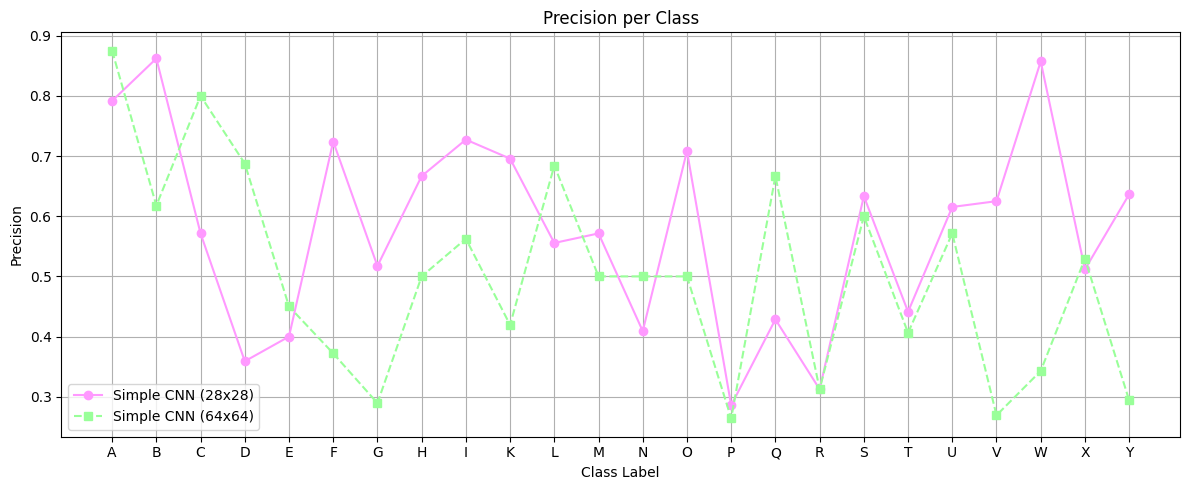

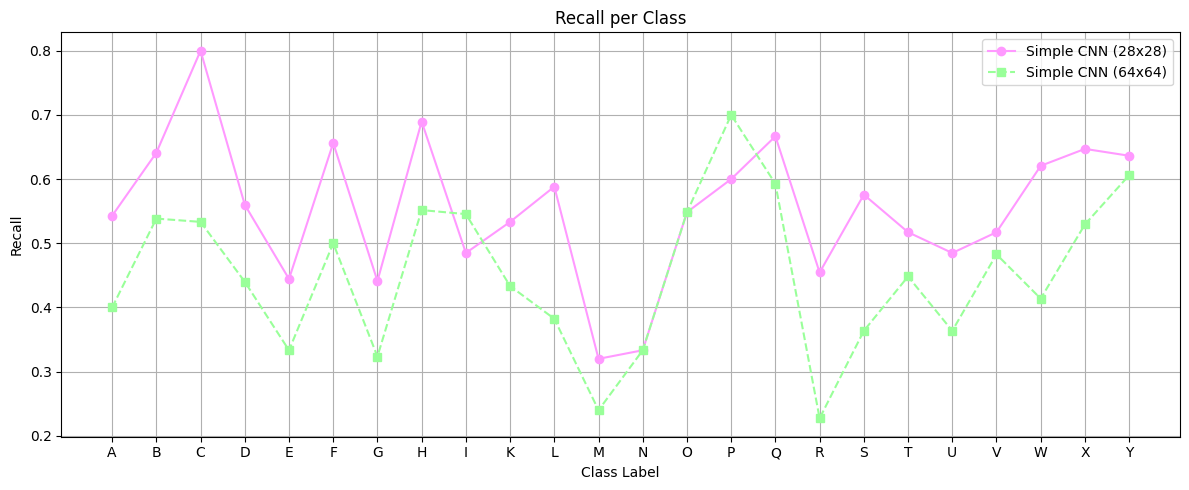

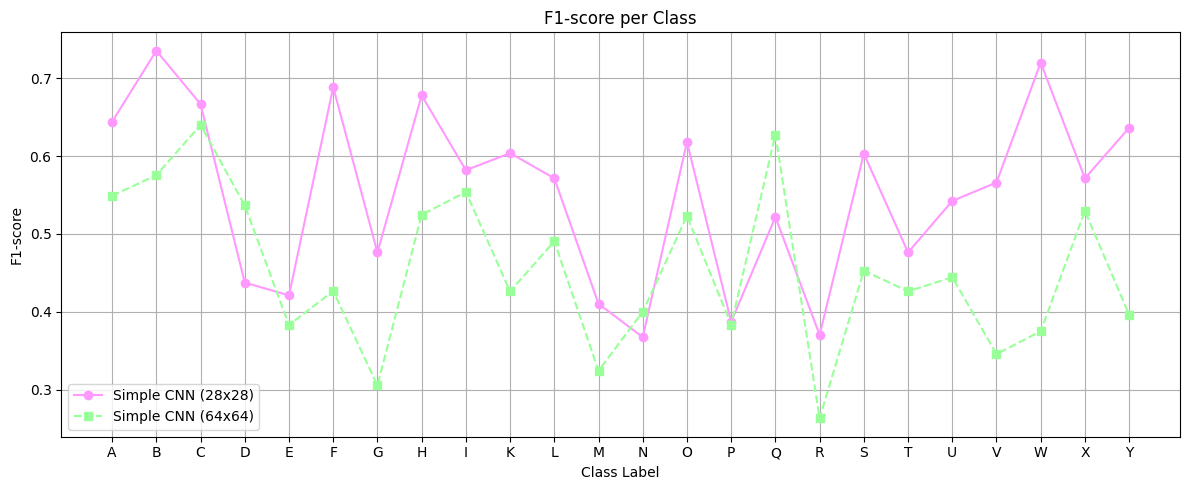

In [ ]:

metrics = ['precision', 'recall', 'f1-score']

for metric in metrics:
    plt.figure(figsize=(12, 5))
    plt.plot(report_28[metric], label='Simple CNN (28x28)', color ='#FF99FF',  marker='o', linestyle='-')
    plt.plot(report_64[metric], label='Simple CNN (64x64)', color ='#99FF99',marker='s', linestyle='--')
    plt.title(f'{metric.capitalize()} per Class')
    plt.xlabel('Class Label')
    plt.ylabel(metric.capitalize())
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


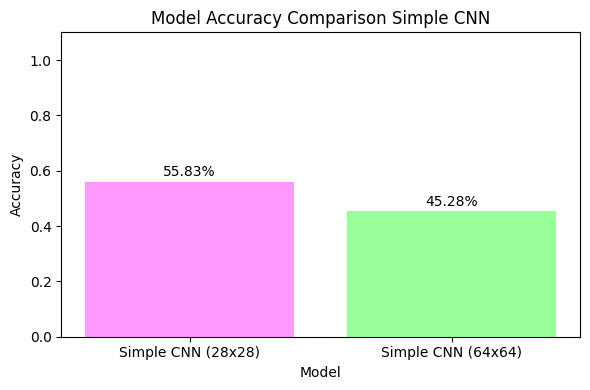

In [ ]:
accuracies = [acc_s_28, acc_s_64]  # Your recorded accuracies
models = ['Simple CNN (28x28)', 'Simple CNN (64x64)']

plt.figure(figsize=(6,4))
bars = plt.bar(models, accuracies, color=['#FF99FF', '#99FF99'])
plt.title("Model Accuracy Comparison Simple CNN")
plt.xlabel("Model")
plt.ylabel("Accuracy")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f'{height*100:.2f}%', ha='center', va='bottom')
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


# **Improved CNN**

In [ ]:
model_28_improved = improved_cnn(input_shape=(28, 28, 1), num_classes=len(labels))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history_28_improved = model_28_improved.fit(
    X_train_28, y_train_28,
    #epochs = 10,
    epochs=TRAINING_CONFIG["epochs"],
    batch_size=TRAINING_CONFIG["batch_size"],
    validation_data=(X_test_28, y_test_28),
    callbacks=[TRAINING_CONFIG["early_stopping"]],
    verbose=1
)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.0953 - loss: 3.6791 - val_accuracy: 0.0472 - val_loss: 3.3007
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.2746 - loss: 2.5359 - val_accuracy: 0.0500 - val_loss: 3.6663
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.3986 - loss: 2.0587 - val_accuracy: 0.0569 - val_loss: 4.4387
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.4999 - loss: 1.7038 - val_accuracy: 0.0639 - val_loss: 5.9870
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.5877 - loss: 1.4119 - val_accuracy: 0.0889 - val_loss: 6.3128
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6496 - loss: 1.2517 - val_accuracy: 0.2125 - val_loss: 4.3142
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.6839 - loss: 1.0852 - val_accuracy: 0.5028 - val_loss: 1.8292
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7337 - loss: 0.9392 - val_accuracy: 0.5625 - v

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
[Improved CNN (28x28)] Final Accuracy:  66.67%
[Improved CNN (28x28)] Final Loss: 1.2587

Classification Report:
              precision    recall  f1-score   support

           A       0.86      0.51      0.64        35
           B       0.74      0.72      0.73        39
           C       0.77      0.80      0.79        30
           D       0.77      0.80      0.78        25
           E       0.43      0.48      0.46        27
           F       0.69      0.69      0.69        32
           G       0.84      0.62      0.71        34
           H       0.79      0.76      0.77        29
           I       0.84      0.64      0.72        33
           K       0.89      0.53      0.67        30
           L       0.80      0.71      0.75        34
           M       0.53      0.64      0.58        25
           N       0.74      0.63      0.68        27
           O       0.48      0.84      0.61        31
           P       0.48      0.75   

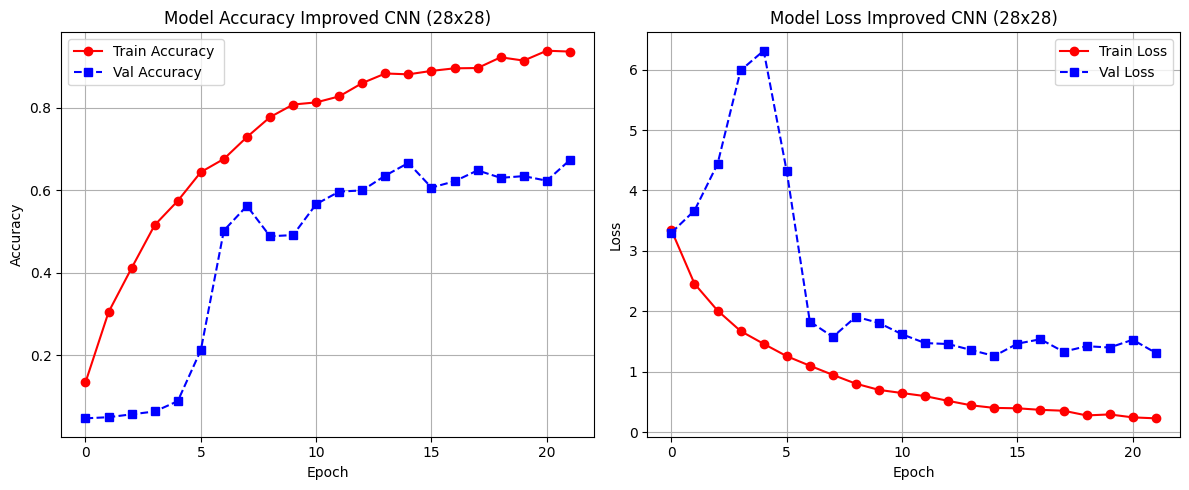

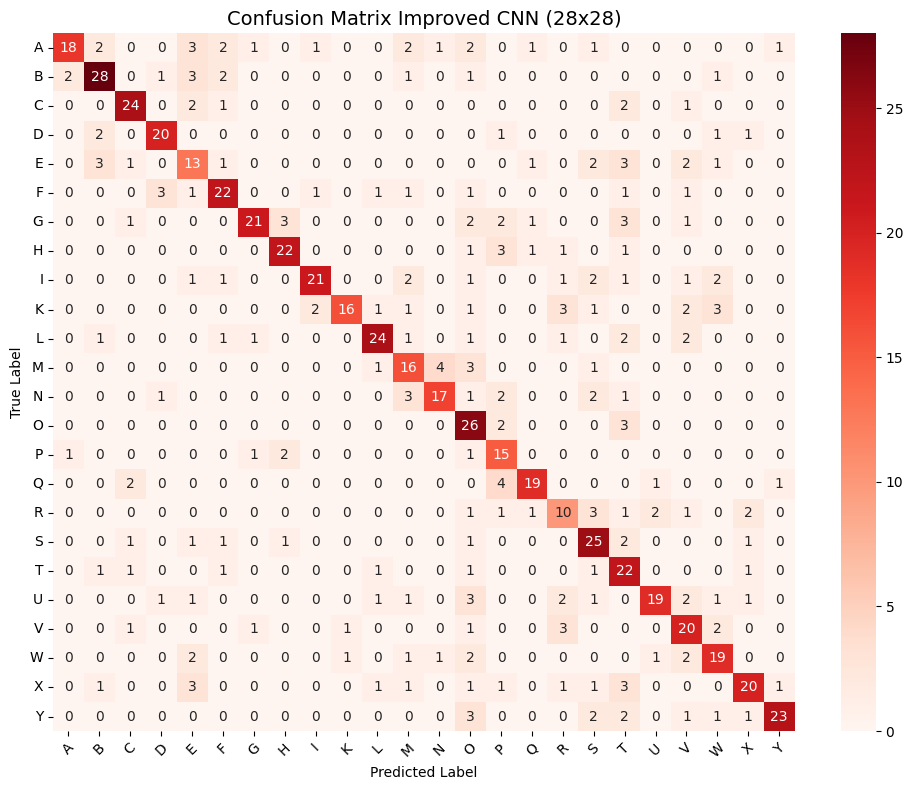

In [ ]:
loss_i_28 , acc_i_28 = result_summary('Improved CNN (28x28)',model_28_improved, history_28_improved, X_test_28, y_test_28, class_labels=labels)


In [ ]:
model_28_improved.save("/content/drive/MyDrive/ASL-Project/models/cnn_improved_28x28.h5")


In [ ]:
model_64_improved = improved_cnn(input_shape=(64, 64, 1), num_classes=len(labels))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history_64_improved = model_64_improved.fit(
    X_train_64, y_train_64,
    epochs=TRAINING_CONFIG["epochs"],
    batch_size=TRAINING_CONFIG["batch_size"],
    validation_data=(X_test_64, y_test_64),
    callbacks=[TRAINING_CONFIG["early_stopping"]],
    verbose=1
)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 290ms/step - accuracy: 0.0941 - loss: 3.6682 - val_accuracy: 0.0486 - val_loss: 3.4100
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 284ms/step - accuracy: 0.3026 - loss: 2.4326 - val_accuracy: 0.0889 - val_loss: 3.4782
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 442ms/step - accuracy: 0.4959 - loss: 1.8117 - val_accuracy: 0.0750 - val_loss: 3.9683
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 357ms/step - accuracy: 0.6114 - loss: 1.3719 - val_accuracy: 0.0736 - val_loss: 4.1281
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 288ms/step - accuracy: 0.7405 - loss: 0.9429 - val_accuracy: 0.0833 - val_loss: 4.9044
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - accuracy: 0.7960 - loss: 0.7515 - val_accuracy: 0.2028 - val_loss: 2.8091
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 287ms/step - accuracy: 0.8650 - loss: 0.5552 - val_accuracy: 0.4319 - val_loss: 2.0357
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 334ms/step - accuracy: 0.9019 - loss: 0.4212 - val_accu

In [ ]:
model_64_improved.save("/content/drive/MyDrive/ASL-Project/models/cnn_improved_64x64.h5")

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step
[Improved CNN (64x64)] Final Accuracy:  63.75%
[Improved CNN (64x64)] Final Loss: 1.3774

Classification Report:
              precision    recall  f1-score   support

           A       0.73      0.69      0.71        35
           B       0.61      0.69      0.65        39
           C       0.79      0.73      0.76        30
           D       0.61      0.68      0.64        25
           E       0.45      0.37      0.41        27
           F       0.64      0.72      0.68        32
           G       0.67      0.71      0.69        34
           H       0.61      0.66      0.63        29
           I       0.67      0.55      0.60        33
           K       0.60      0.60      0.60        30
           L       0.68      0.50      0.58        34
           M       0.42      0.76      0.54        25
           N       0.68      0.63      0.65        27
           O       0.74      0.65      0.69        31
           P       0.57      0.65   

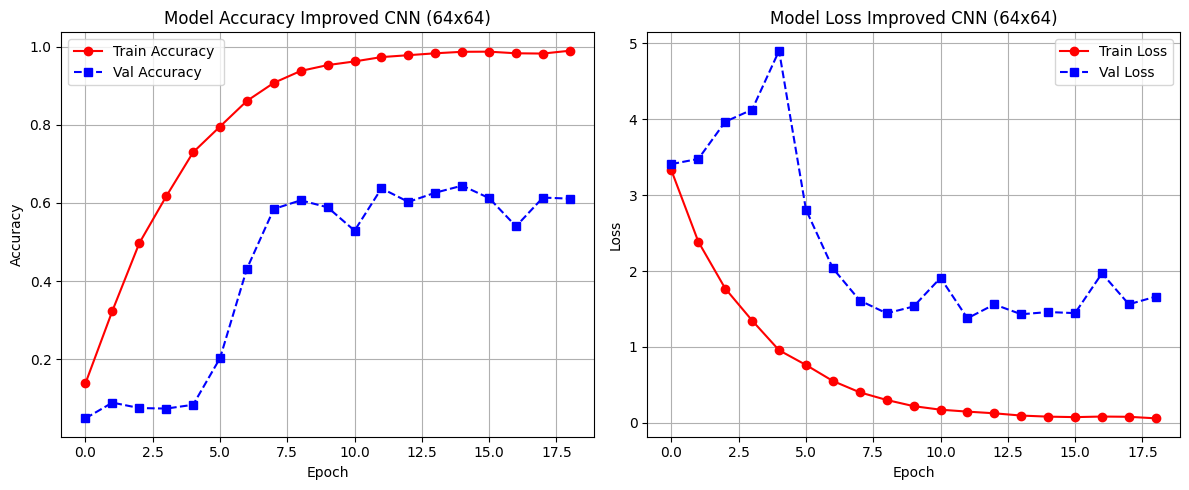

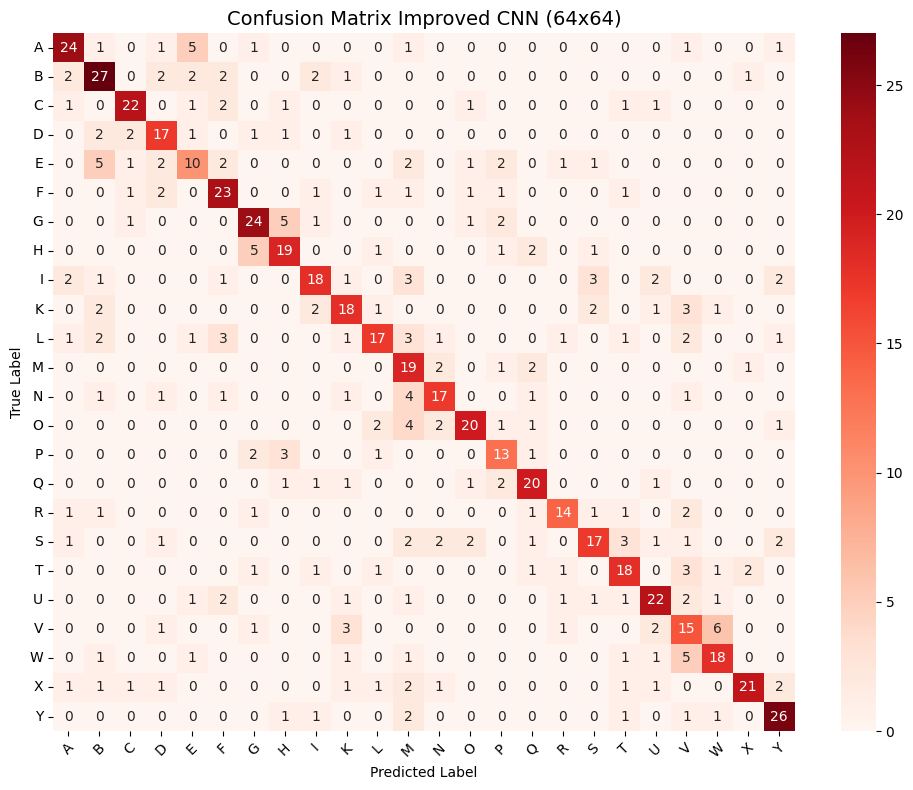

In [ ]:
loss_i_64 , acc_i_64 = result_summary('Improved CNN (64x64)',model_64_improved, history_64_improved, X_test_64, y_test_64, class_labels=labels)


# **Data Augmentation**

In [ ]:
datagen_28 = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Fit the generator to training data (optional but good)
datagen_28.fit(X_train_28)


In [ ]:
model_28_augmented = improved_cnn(input_shape=(28, 28, 1), num_classes=len(labels))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history_28_augmented = model_28_augmented.fit(
    datagen_28.flow(X_train_28, y_train_28, batch_size=TRAINING_CONFIG["batch_size"]),
    epochs=TRAINING_CONFIG["epochs"],
    validation_data=(X_test_28, y_test_28),
    callbacks=[TRAINING_CONFIG["early_stopping"]],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.0635 - loss: 3.8388 - val_accuracy: 0.0431 - val_loss: 3.2934
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.1491 - loss: 3.1122 - val_accuracy: 0.0514 - val_loss: 4.0582
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.2153 - loss: 2.7687 - val_accuracy: 0.0347 - val_loss: 6.0629
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.2759 - loss: 2.5858 - val_accuracy: 0.0389 - val_loss: 6.6009
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.3041 - loss: 2.3734 - val_accuracy: 0.1000 - val_loss: 4.4270
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.3298 - loss: 2.2415 - val_accuracy: 0.3444 - val_loss: 2.4031
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.3940 - loss: 2.0634 - val_accuracy: 0.4833 - val_loss: 1.9039
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.3896 - loss: 2.0150 - val_accuracy: 0.4889 - v

In [ ]:
model_28_augmented.save("/content/drive/MyDrive/ASL-Project/models/cnn_augmented_28x28.h5")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[Data Augmentation (28x28)] Final Accuracy:  70.42%
[Data Augmentation (28x28)] Final Loss: 1.1104

Classification Report:
              precision    recall  f1-score   support

           A       0.88      0.60      0.71        35
           B       0.90      0.67      0.76        39
           C       0.96      0.87      0.91        30
           D       0.85      0.88      0.86        25
           E       0.45      0.48      0.46        27
           F       0.79      0.84      0.82        32
           G       0.60      0.76      0.68        34
           H       0.67      0.76      0.71        29
           I       0.76      0.67      0.71        33
           K       0.64      0.83      0.72        30
           L       0.85      0.82      0.84        34
           M       0.81      0.52      0.63        25
           N       0.67      0.59      0.63        27
           O       0.69      0.77      0.73        31
           P       0.48   

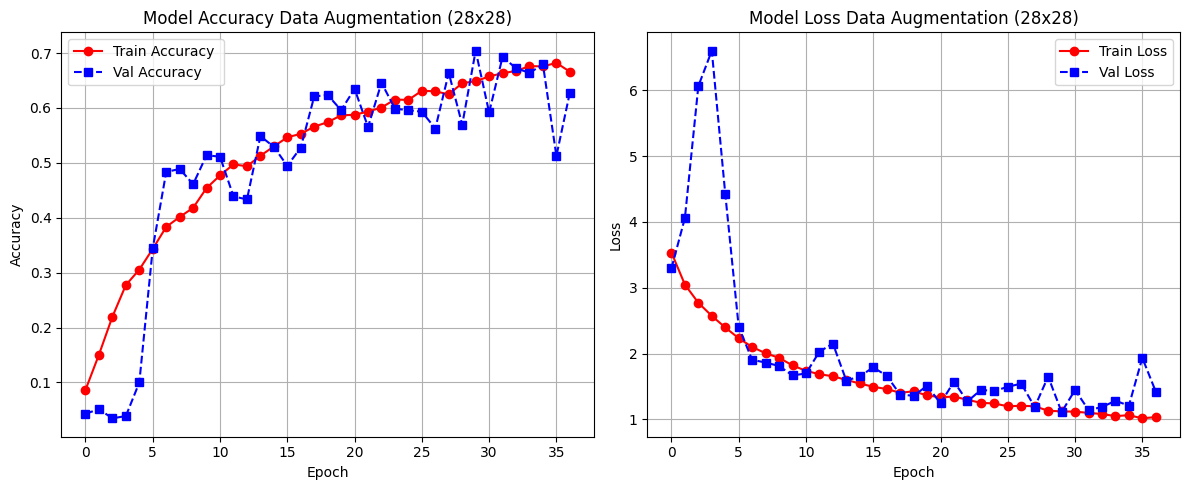

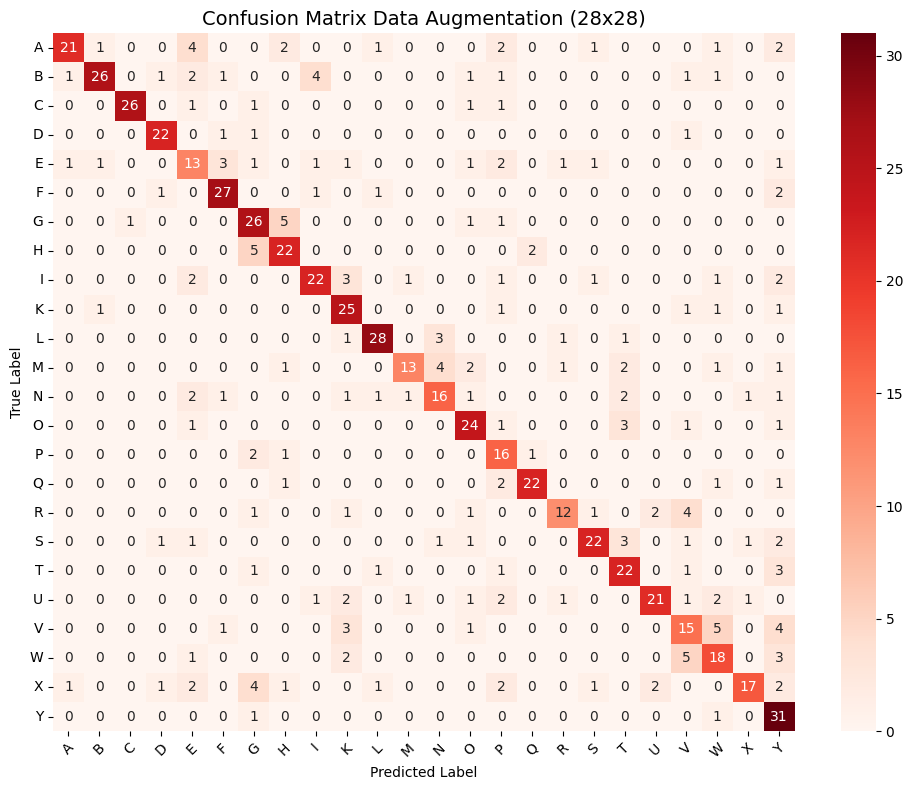

In [ ]:
loss_28_a , acc_28_a = result_summary('Data Augmentation (28x28)',model_28_augmented, history_28_augmented, X_test_28, y_test_28, class_labels=labels)


In [ ]:

datagen_64 = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Fit the generator to training data (optional but good)
datagen_64.fit(X_train_64)


In [ ]:
model_64_augmented = improved_cnn(input_shape=(64, 64, 1), num_classes=len(labels))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history_64_augmented = model_64_augmented.fit(
    datagen_64.flow(X_train_64, y_train_64, batch_size=TRAINING_CONFIG["batch_size"]),
    epochs=TRAINING_CONFIG["epochs"],
    validation_data=(X_test_64, y_test_64),
    callbacks=[TRAINING_CONFIG["early_stopping"]],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 311ms/step - accuracy: 0.0694 - loss: 3.7736 - val_accuracy: 0.0486 - val_loss: 3.2550
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 300ms/step - accuracy: 0.1529 - loss: 3.0570 - val_accuracy: 0.0417 - val_loss: 3.5645
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 290ms/step - accuracy: 0.2145 - loss: 2.7856 - val_accuracy: 0.0556 - val_loss: 3.5969
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.2476 - loss: 2.5599 - val_accuracy: 0.1167 - val_loss: 3.3036
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 303ms/step - accuracy: 0.3060 - loss: 2.3733 - val_accuracy: 0.1639 - val_loss: 3.0352
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - accuracy: 0.3705 - loss: 2.1957 - val_accuracy: 0.3042 - val_loss: 2.4689
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 303ms/step - accuracy: 0.3965 - loss: 2.0111 - val_accuracy: 0.3000 - val_loss: 2.3720
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step - accuracy: 0.4199 - loss: 1.9530 - val_accuracy: 0.379

In [ ]:
model_64_augmented.save("/content/drive/MyDrive/ASL-Project/models/cnn_augmented_64x64.h5")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
[Data Augmentation (64x64)] Final Accuracy:  68.89%
[Data Augmentation (64x64)] Final Loss: 1.1109

Classification Report:
              precision    recall  f1-score   support

           A       0.69      0.63      0.66        35
           B       0.79      0.77      0.78        39
           C       0.85      0.73      0.79        30
           D       0.66      0.84      0.74        25
           E       0.45      0.52      0.48        27
           F       0.86      0.75      0.80        32
           G       0.74      0.74      0.74        34
           H       0.63      0.83      0.72        29
           I       0.64      0.64      0.64        33
           K       0.91      0.67      0.77        30
           L       0.74      0.76      0.75        34
           M       0.57      0.80      0.67        25
           N       0.71      0.63      0.67        27
           O       0.73      0.71      0.72        31
           P       0.70   

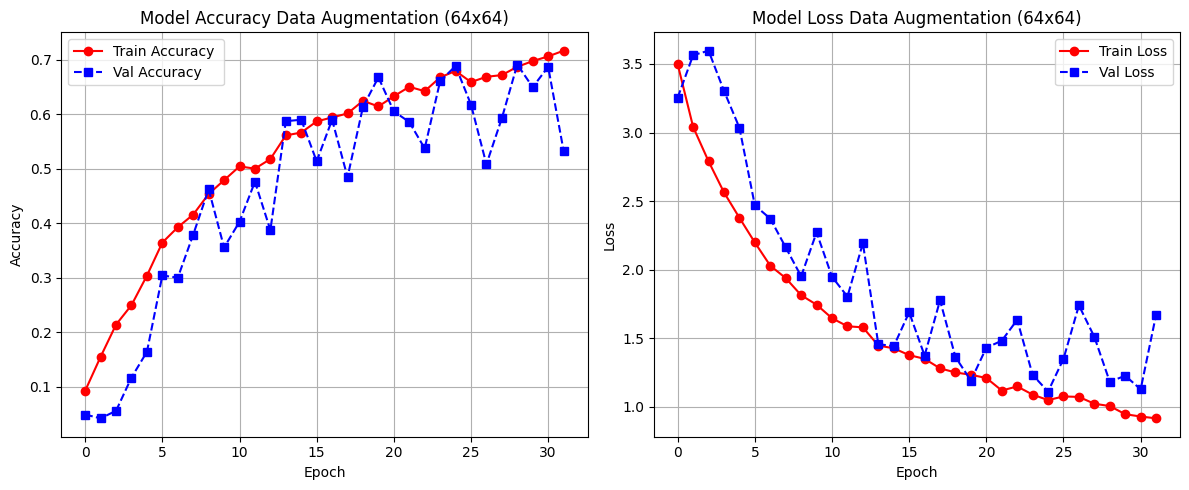

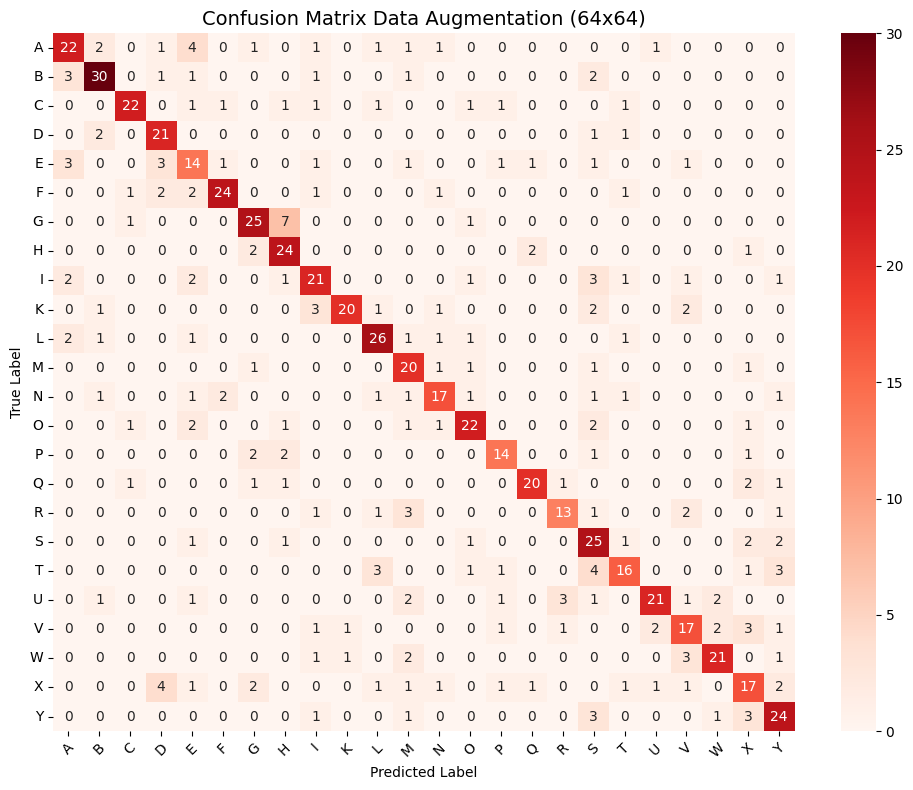

In [ ]:
loss_64_a, acc_64_a = result_summary('Data Augmentation (64x64)',model_64_augmented, history_64_augmented, X_test_64, y_test_64, class_labels=labels)



# **Transfer Learning - MobileNet**

In [ ]:
X_train_224, X_test_224, y_train_224, y_test_224 = load_and_preprocess_csv("/content/drive/MyDrive/ASL-Project/master_grayscale_224x224.csv", image_size=(224, 224))


In [ ]:
# Convert grayscale to RGB by repeating the single channel
X_train_224_rgb = np.repeat(X_train_224, 3, axis=-1)
X_test_224_rgb = np.repeat(X_test_224, 3, axis=-1)

print("New shape (RGB):", X_train_224_rgb.shape)  # Should be (samples, 224, 224, 3)


New shape (RGB): (2880, 224, 224, 3)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

def build_transfer_model(input_shape=(224, 224, 3), num_classes=24, freeze_base=True):
    """
    Builds a transfer learning model using MobileNetV2 as the base.

    Args:
        input_shape (tuple): Input shape of the images (must be 3 channels).
        num_classes (int): Number of output classes (24 for A–Y excluding J, Z).
        freeze_base (bool): If True, freeze MobileNetV2 base layers.

    Returns:
        Compiled Keras model.
    """
    # Load MobileNetV2 base with pretrained weights, no top classifier
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Optionally freeze the base model
    if freeze_base:
        for layer in base_model.layers:
            layer.trainable = False

    # Custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
model_transfer = build_transfer_model(input_shape=(224, 224, 3), num_classes=len(labels))


In [ ]:
#model_transfer.summary()

In [ ]:
history_transfer = model_transfer.fit(
    X_train_224_rgb, y_train_224,
    #epochs = 30,
    #batch_size = 16,
    epochs=TRAINING_CONFIG["epochs"],
    batch_size=TRAINING_CONFIG["batch_size"],
    validation_data=(X_test_224_rgb, y_test_224),
    callbacks=[TRAINING_CONFIG["early_stopping"]],
    verbose=1
)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.1166 - loss: 3.1864 - val_accuracy: 0.4500 - val_loss: 1.9989
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3858 - loss: 2.0463 - val_accuracy: 0.6722 - val_loss: 1.3043
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5539 - loss: 1.4575 - val_accuracy: 0.7153 - val_loss: 1.0597
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6130 - loss: 1.2253 - val_accuracy: 0.7542 - val_loss: 0.8745
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.6748 - loss: 1.0360 - val_accuracy: 0.7806 - val_loss: 0.8037
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.7073 - loss: 0.9378 - val_accuracy: 0.7958 - val_loss: 0.6966
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7527 - loss: 0.7922 - val_accuracy: 0.8208 - val_loss: 0.6480
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7829 - loss: 0.7032 - val_accuracy: 0.8361 

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step
[Transfer Learning] Final Accuracy:  88.89%
[Transfer Learning] Final Loss: 0.3259

Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.86      0.92        35
           B       0.91      1.00      0.95        39
           C       0.94      0.97      0.95        30
           D       1.00      0.96      0.98        25
           E       0.75      0.89      0.81        27
           F       0.97      0.94      0.95        32
           G       0.88      0.88      0.88        34
           H       0.84      0.93      0.89        29
           I       0.96      0.70      0.81        33
           K       0.81      0.87      0.84        30
           L       0.97      0.88      0.92        34
           M       0.88      0.84      0.86        25
           N       0.86      0.89      0.87        27
           O       0.93      0.87      0.90        31
           P       0.90      0.95      0.

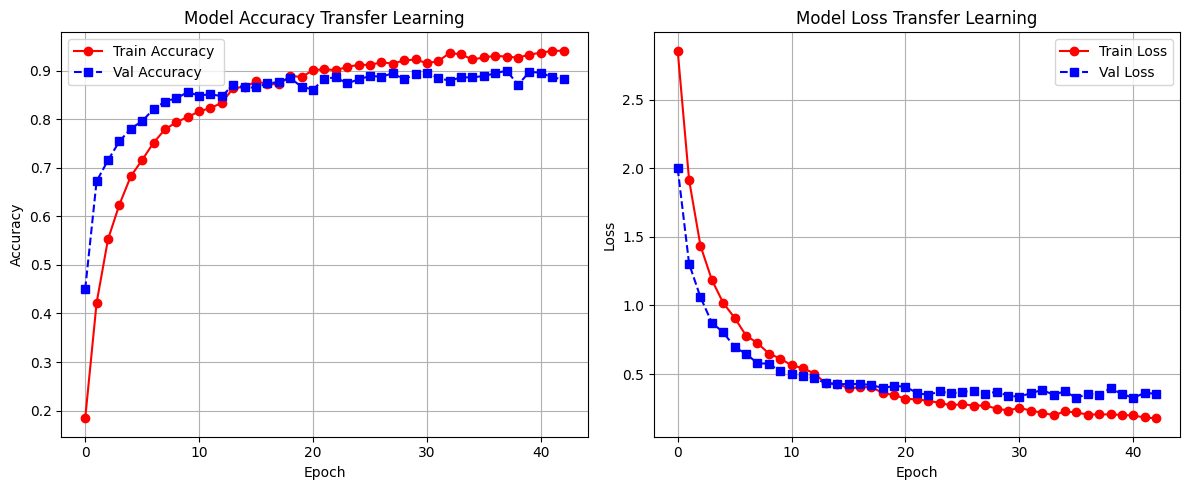

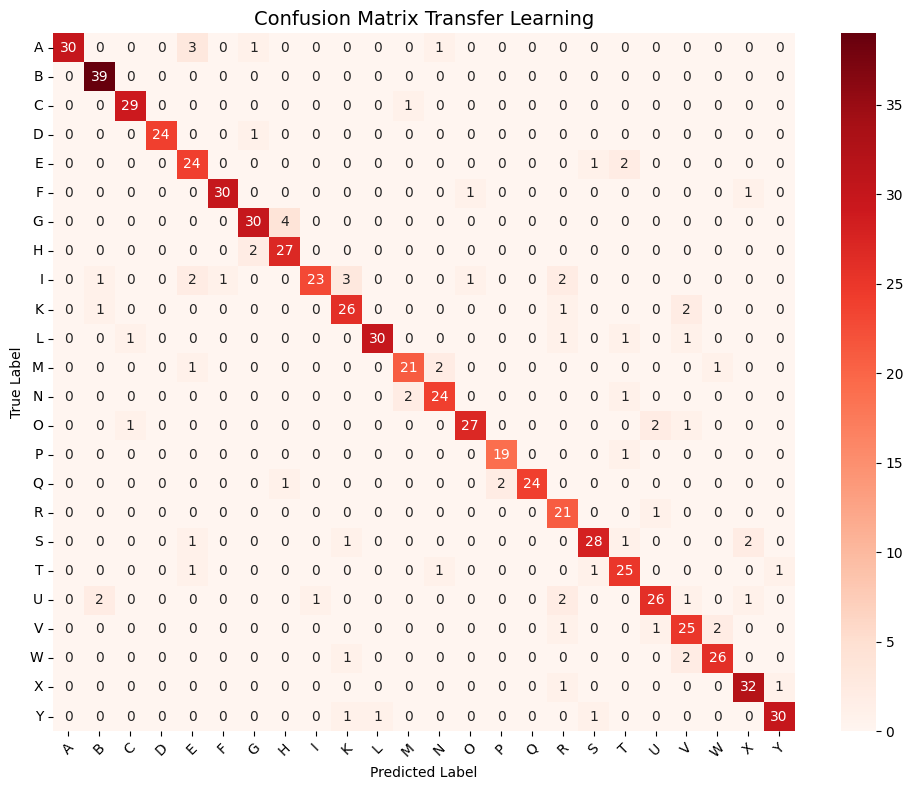

In [ ]:
loss_tl, acc_tl = result_summary('Transfer Learning',model_transfer, history_transfer, X_test_224_rgb, y_test_224, class_labels=labels)


In [ ]:
model_transfer.save("/content/drive/MyDrive/ASL-Project/models/transfer.h5")

# **FineTune Transfer Learning**

In [ ]:
# Unfreeze last 20 layers
for layer in model_transfer.layers[-20:]:
    layer.trainable = True

# Recompile with a lower learning rate
model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen_aug.fit(X_train_224_rgb)


In [ ]:
history_finetuned = model_transfer.fit(
    datagen_aug.flow(X_train_224_rgb, y_train_224),
    #epochs=TRAINING_CONFIG["epochs"],
    epochs=10,
    batch_size=TRAINING_CONFIG["batch_size"],
    validation_data=(X_test_224_rgb, y_test_224),
    #callbacks=[TRAINING_CONFIG["early_stopping"]],
    verbose=1
)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 358ms/step - accuracy: 0.7859 - loss: 0.6691 - val_accuracy: 0.8806 - val_loss: 0.3905
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 364ms/step - accuracy: 0.7970 - loss: 0.6128 - val_accuracy: 0.8819 - val_loss: 0.3905
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 347ms/step - accuracy: 0.7895 - loss: 0.6148 - val_accuracy: 0.8875 - val_loss: 0.3818
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 360ms/step - accuracy: 0.8313 - loss: 0.5509 - val_accuracy: 0.8861 - val_loss: 0.3841
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - accuracy: 0.8042 - loss: 0.5550 - val_accuracy: 0.8917 - val_loss: 0.3859
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.8412 - loss: 0.5179 - val_accuracy: 0.8917 - val_loss: 0.3829
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 360ms/step - accuracy: 0.8296 - loss: 0.5281 - val_accuracy: 0.8903 - val_loss: 0.3816
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 347ms/step - accuracy: 0.8338 - loss: 0.5520 - val_accu

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
[Finetuned Transfer Learning] Final Accuracy:  89.72%
[Finetuned Transfer Learning] Final Loss: 0.3618

Classification Report:
              precision    recall  f1-score   support

           A       0.94      0.94      0.94        35
           B       0.95      1.00      0.97        39
           C       0.97      0.93      0.95        30
           D       0.96      0.96      0.96        25
           E       0.70      0.78      0.74        27
           F       0.97      0.94      0.95        32
           G       0.97      0.82      0.89        34
           H       0.93      0.93      0.93        29
           I       1.00      0.82      0.90        33
           K       0.93      0.83      0.88        30
           L       1.00      0.88      0.94        34
           M       0.79      0.88      0.83        25
           N       0.82      0.85      0.84        27
           O       0.88      0.90      0.89        31
           P       0.8

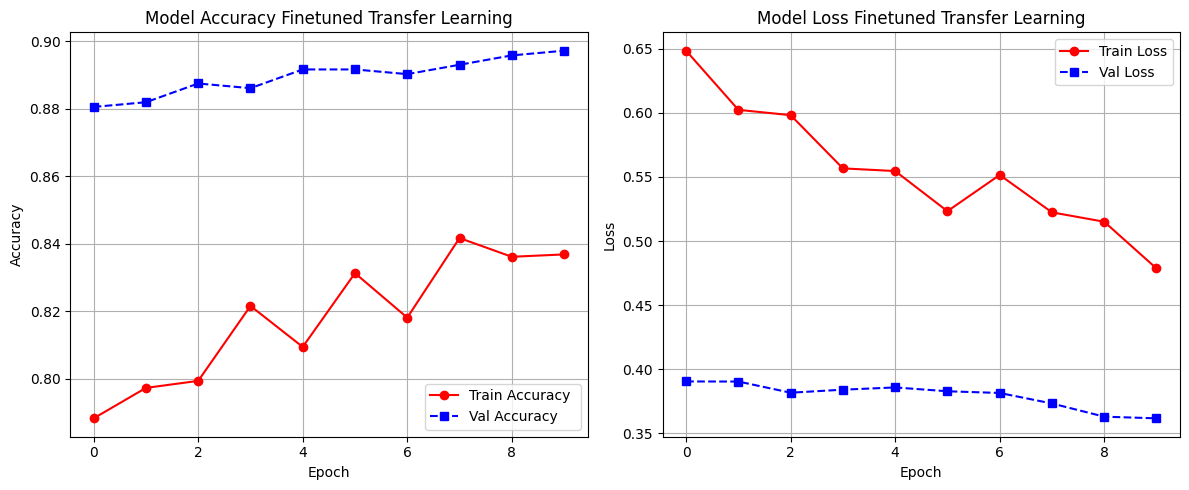

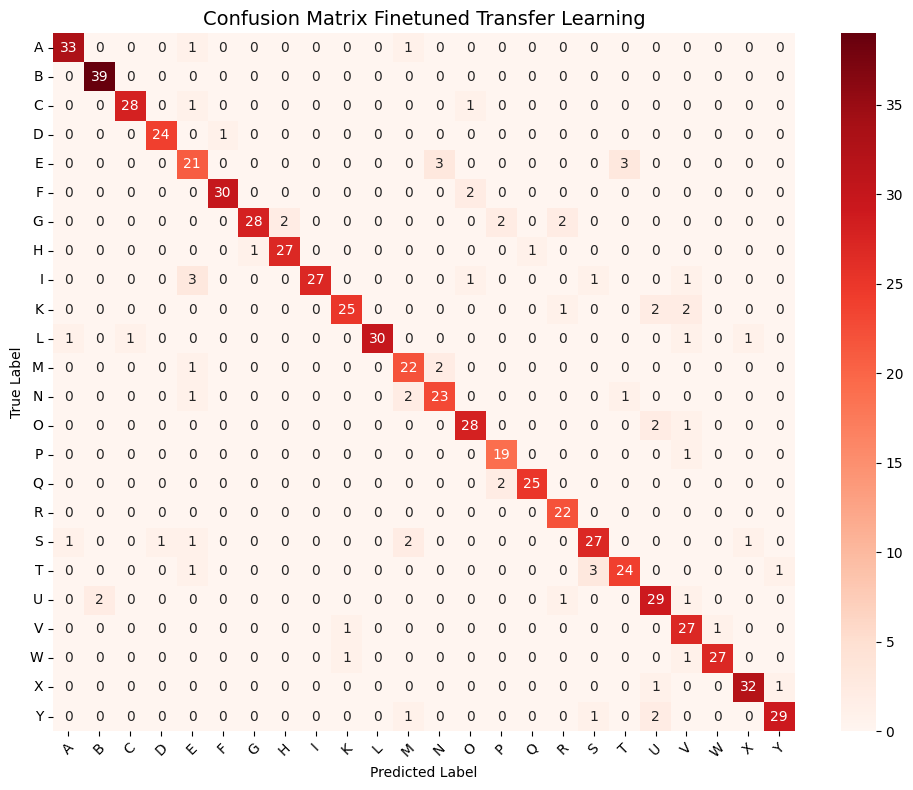

In [ ]:
loss_tlf , acc_tlf = result_summary('Finetuned Transfer Learning',model_transfer, history_finetuned, X_test_224_rgb, y_test_224, class_labels=labels)


In [ ]:
model_transfer.save("/content/drive/MyDrive/ASL-Project/models/transfer_finetune.h5")

# **Vision Transformers**

In [ ]:
!pip install transformers datasets


In [ ]:
from transformers import ViTFeatureExtractor, TFViTForImageClassification
import tensorflow as tf
import numpy as np


In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# Convert pixel values from float32 to uint8
X_train_uint8 = (X_train_224_rgb * 255).astype(np.uint8)
X_test_uint8 = (X_test_224_rgb * 255).astype(np.uint8)

# Apply feature extractor
train_features = feature_extractor(images=list(X_train_uint8), return_tensors="tf")["pixel_values"]
test_features = feature_extractor(images=list(X_test_uint8), return_tensors="tf")["pixel_values"]

print("Feature shape (train):", train_features.shape)  # Should be (samples, 3, 224, 224)


Feature shape (train): (2880, 3, 224, 224)


In [ ]:
model_vit = TFViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=24,
    ignore_mismatched_sizes=True
)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
Some weights of TFViTForImageClassification were not initialized from the model checkpoint are newly initialize

In [ ]:
from transformers import create_optimizer

# Compute the total number of training steps.
# For a rough estimate, you can calculate:
# num_train_steps = (number of training samples // batch_size) * epochs
# Here, we'll assume a value of 1000 as before, and set num_warmup_steps to 100.
optimizer, _ = create_optimizer(
    init_lr=1e-4,
    num_train_steps=1000,
    num_warmup_steps=100,
    weight_decay_rate=0.01
)

model_vit.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [ ]:
history_vit = model_vit.fit(
    train_features, y_train_224,
    validation_data=(test_features, y_test_224),
    epochs=10,
    batch_size=16,
    # Use the EarlyStoppingCallback from Hugging Face Transformers
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=7)],
    verbose=1
)


Epoch 1/10
180/180 [==============================] - 138s 660ms/step - loss: 1.7159 - accuracy: 0.5413 - val_loss: 0.3293 - val_accuracy: 0.9222
Epoch 2/10
180/180 [==============================] - 122s 678ms/step - loss: 0.1653 - accuracy: 0.9573 - val_loss: 0.1270 - val_accuracy: 0.9667
Epoch 3/10
180/180 [==============================] - 124s 690ms/step - loss: 0.0245 - accuracy: 0.9979 - val_loss: 0.0620 - val_accuracy: 0.9861
Epoch 4/10
180/180 [==============================] - 125s 693ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0553 - val_accuracy: 0.9861
Epoch 5/10
180/180 [==============================] - 125s 697ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0524 - val_accuracy: 0.9861
Epoch 6/10
180/180 [==============================] - 126s 698ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0520 - val_accuracy: 0.9861
Epoch 7/10
180/180 [==============================] - 125s 695ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0520 -

In [ ]:
def result_summary_vit(title, model, history, X_test, y_test, class_labels=None):
    """
    Summarizes model performance:
    - Accuracy & loss plots
    - Classification report
    - Seaborn confusion matrix

    Args:
        model: Trained Keras model.
        history: History object from model.fit().
        X_test: Test set images.
        y_test: One-hot encoded test labels.
        class_labels: Optional list of class labels (e.g., A–Y).
    """
    # Predictions
    # Get the logits from the model prediction
    predictions = model.predict(X_test)

    # Check if the model returns logits directly or within a TFSequenceClassifierOutput object
    if hasattr(predictions, 'logits'):
        logits = predictions.logits
    else:
        logits = predictions  # Assuming logits are returned directly

    # Apply softmax to get probabilities
    y_pred = tf.nn.softmax(logits).numpy().argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    # === Final Accuracy ===
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"[{title}] Final Accuracy:  {acc * 100:.2f}%")
    print(f"[{title}] Final Loss: {loss:.4f}\n")

    # === Classification Report ===
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # === Accuracy & Loss Plots ===
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy ',
            color='red', linestyle='-' , marker = 'o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy ',
            color='blue', linestyle='--', marker ='s')
    plt.title("Model Accuracy " + title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # === Loss Plot ===
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss',
            color='red', linestyle='-', marker = 'o')
    plt.plot(history.history['val_loss'], label='Val Loss',
            color='blue', linestyle='--' , marker = 's')
    plt.title("Model Loss " + title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



    # === Confusion Matrix (Seaborn - Cleaner Layout) ===
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix " + title, fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return loss, acc

23/23 [==============================] - 9s 396ms/step
[Vision Transformer] Final Accuracy:  98.61%
[Vision Transformer] Final Loss: 0.0520

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        35
           B       1.00      1.00      1.00        39
           C       1.00      0.97      0.98        30
           D       0.96      0.96      0.96        25
           E       0.96      0.96      0.96        27
           F       0.97      0.97      0.97        32
           G       0.97      1.00      0.99        34
           H       1.00      0.97      0.98        29
           I       1.00      0.97      0.98        33
           K       1.00      1.00      1.00        30
           L       1.00      1.00      1.00        34
           M       0.89      0.96      0.92        25
           N       0.93      0.93      0.93        27
           O       1.00      1.00      1.00        31
           P       1.00  

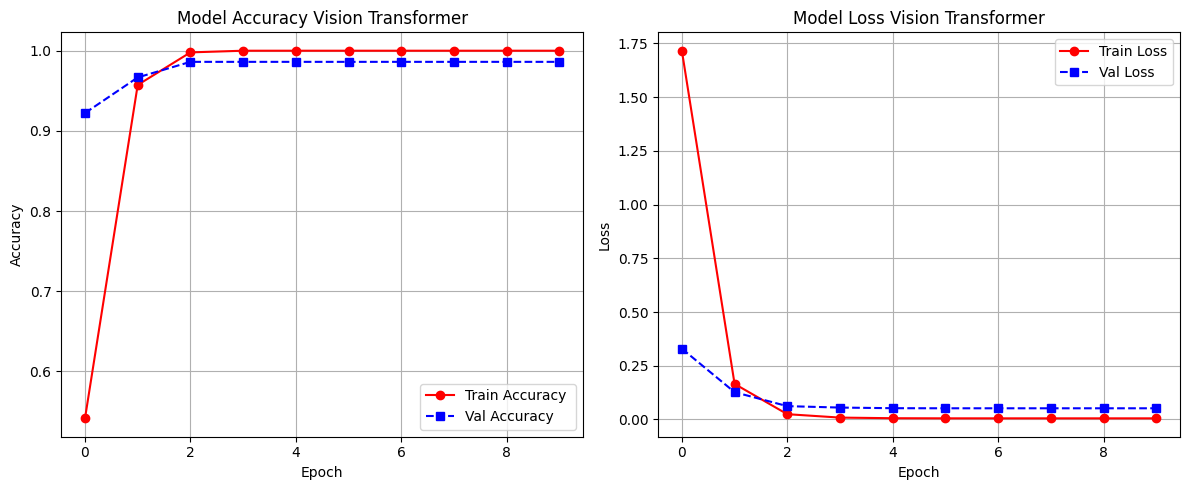

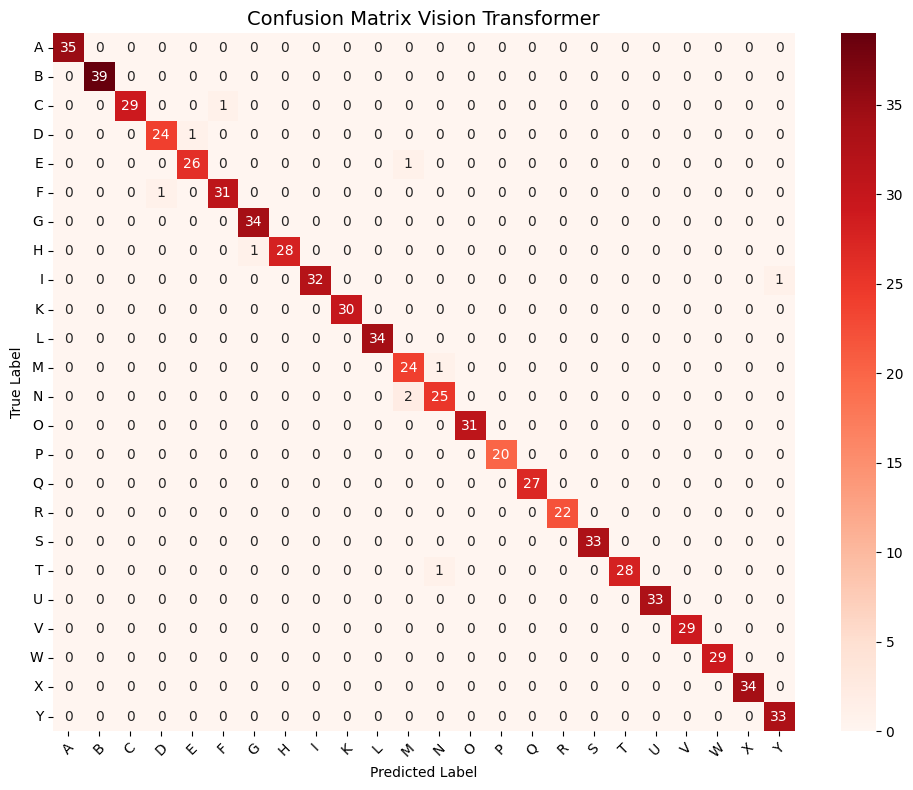

In [ ]:
loss_v , acc_v = result_summary_vit('Vision Transformer',model_vit, history_vit, test_features, y_test_224, class_labels=labels)


In [ ]:
model_vit.save_pretrained("/content/drive/MyDrive/ASL-Project/models/visiontransformer")

# **Demo**

In [ ]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from transformers import ViTFeatureExtractor, TFViTForImageClassification

# Load model and extractor once
model_vit = TFViTForImageClassification.from_pretrained("/content/drive/MyDrive/ASL-Project/models/visiontransformer")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# ASL class labels (no J, Z)
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
          'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

def predict_uploaded_images_vit():
    uploaded = files.upload()

    plt.figure(figsize=(15, 6))

    for i, filename in enumerate(uploaded.keys()):
        img = Image.open(filename).convert("RGB")
        img = img.resize((224, 224))

        # Extract features
        inputs = feature_extractor(images=img, return_tensors="tf")
        outputs = model_vit(**inputs)
        pred_logits = outputs.logits.numpy()
        pred_class = np.argmax(pred_logits, axis=1)[0]
        predicted_label = labels[pred_class]

        # Show image with prediction
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at /content/drive/MyDrive/ASL-Project/models/visiontransformer.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


Saving B15_jpg.rf.0f0628552139144fc67c453e1f1b7b15.jpg to B15_jpg.rf.0f0628552139144fc67c453e1f1b7b15.jpg
Saving G20_jpg.rf.e0c7b5abdee0fb589e576002c76f4ace.jpg to G20_jpg.rf.e0c7b5abdee0fb589e576002c76f4ace.jpg
Saving N6_jpg.rf.3899dd6cc1da66139de57126a250c175.jpg to N6_jpg.rf.3899dd6cc1da66139de57126a250c175.jpg
Saving T1_jpg.rf.877948f560962d1e267a72617d9e1ed4.jpg to T1_jpg.rf.877948f560962d1e267a72617d9e1ed4.jpg


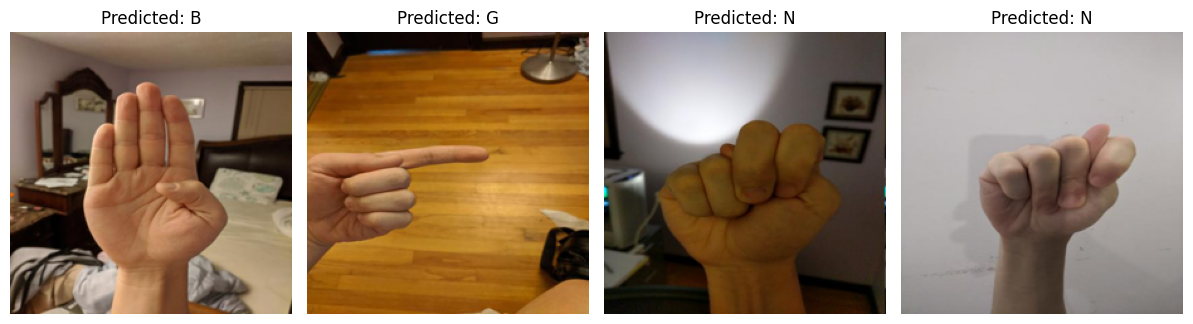

In [ ]:
predict_uploaded_images_vit()
